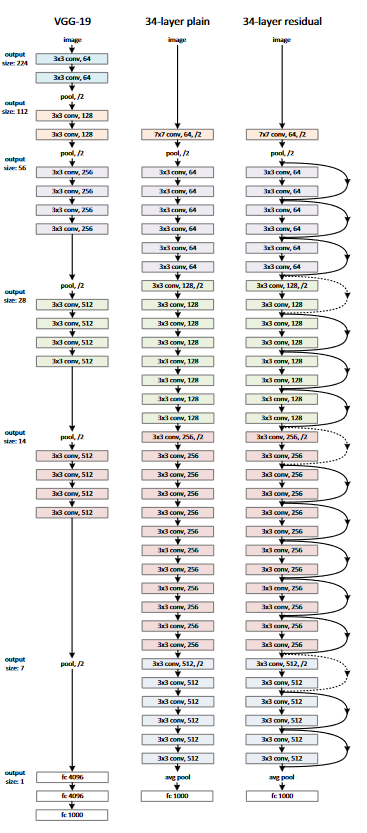


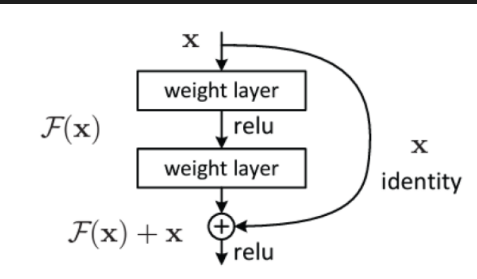

In [49]:
import torch
import torch.nn as nn


In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

The downsample parameter is used to adjust the number of channels when transitioning between layers in the ResNet architecture.

In [51]:
class ResidualBlock34(nn.Module):
  # In a residual block ,
  # kernel size = fixed 3x3 for all layers
  # input shape  = varies
  # output shape = varies
  # stride  = varies
  # padding = fixed 1
  def __init__(self, in_channels:int, out_channels:int, stride:int , downsample = None):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels,out_channels, kernel_size = 3, stride = stride, padding = 1 ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1 ),
        # stride should be 1 here cause input and output shape is same so need to match them
        nn.BatchNorm2d(out_channels),
    )
    self.relu = nn.ReLU()
    self.downsample = downsample

  def forward(self, x):
    original = x
    x = self.conv1(x)
    x = self.conv2(x)
    if self.downsample: # needed if the original image shape is not same as the output obtained from the conv layers
      original = self.downsample(original)
    x += original
    x = self.relu(x)
    return x

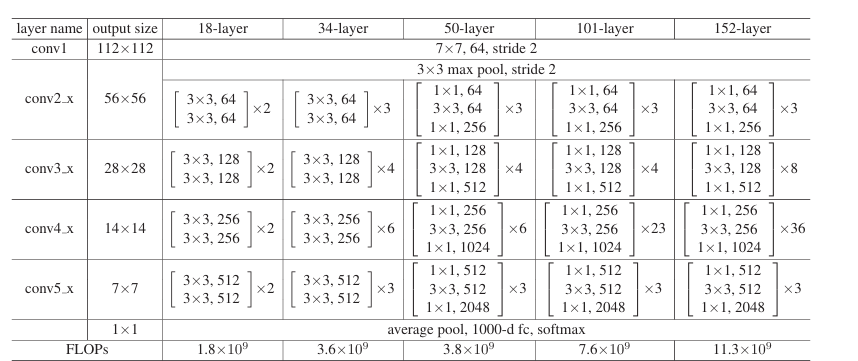

- in resnet-34,total layer = 4 and  in each layer there is [3,4,6,3] resnet blocks
- in resnet-50,total layer = 4 and  in each layer there is [3,4,6,3] resnet blocks
- in resnet-101,total layer = 4 and  in each layer there is [3,4,23,3] resnet blocks  
- in resnet-152,total layer = 4 and  in each layer there is [3,8,36,3] resnet blocks


In [52]:
class resnet34(nn.Module):
    def __init__(self, ResidualBlock34,layers,  num_classes):
        super(resnet34,self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self.create_layer(ResidualBlock34, 64, layers[0], stride=1)
        self.layer1 = self.create_layer(ResidualBlock34, 128, layers[1], stride=2)
        self.layer2 = self.create_layer(ResidualBlock34, 256, layers[2], stride=2)
        self.layer3 = self.create_layer(ResidualBlock34, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, num_classes)

    def create_layer(self, ResidualBlock34, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels),
            )

        all_blocks = []
        all_blocks.append(ResidualBlock34(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        # print(self.in_channels)
        for i in range(num_blocks - 1):
            all_blocks.append(ResidualBlock34(self.in_channels, out_channels, 1 , downsample = None))

        return nn.Sequential(*all_blocks)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [53]:
def test(model):
  x = torch.randn(2,3,224,224)
  y = model(x).to(device)

  print(y.shape)
  return y

In [54]:
resnet18model = resnet34(ResidualBlock34, layers = [2,2,2,2], num_classes = 10)
test(resnet18model)

torch.Size([2, 10])


tensor([[-0.2849, -0.1636, -0.2964, -0.3871, -0.4074,  0.6324, -0.6346,  0.2970,
         -0.9561,  0.4862],
        [-0.2434, -0.1617, -0.2317, -0.3054, -0.4313,  0.7819, -0.6532,  0.3620,
         -0.9633,  0.4460]], device='cuda:0', grad_fn=<ToCopyBackward0>)

In [55]:
resnet34model = resnet34(ResidualBlock34,layers = [3,4,6,3], num_classes = 10)
test(resnet34model)

torch.Size([2, 10])


tensor([[ 0.1471,  0.2677,  0.2092, -0.5741, -0.0751,  1.0525, -0.1544, -0.1257,
          0.5097,  0.8982],
        [ 0.3452,  0.4786,  0.0690, -0.4927,  0.0151,  0.9735, -0.2605,  0.0686,
          0.6679,  1.0258]], device='cuda:0', grad_fn=<ToCopyBackward0>)

resnet 50 has a different architecture for residual block .

In [56]:
class ResidualBlock50(nn.Module):
  def __init__(self, in_channels:int, out_channels:int, stride:int , downsample = None):
    super().__init__()
    self.conv1 = nn.Sequential(
        #Since the kernel size is 1x1, no spatial information is lost during convolution, and hence, no padding is needed (padding = 0)
        nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, padding = 0),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1 ),
        # stride should be 1 here cause input and output shape is same so need to match them
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels * 4 , kernel_size = 1 , stride = 1, padding = 0 ),
        nn.BatchNorm2d(out_channels*4),
        )
    self.relu = nn.ReLU()
    self.downsample = downsample

  def forward(self, x):
    original = x
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    if self.downsample: # needed if the original image shape is not same as the output obtained from the conv layers
      original = self.downsample(original)
    x += original
    x = self.relu(x)
    return x

In [57]:
class resnet50(nn.Module):
  def __init__(self, ResidualBlock50, layers , num_classes):
    super().__init__()
    self.in_channels = 64
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size= 3, stride = 2, padding = 1)
    self.layer0 = self.create_layer(ResidualBlock50 , 64, layers[0], 1)
    self.layer1 = self.create_layer(ResidualBlock50 , 128, layers[1], 2)
    self.layer2 = self.create_layer(ResidualBlock50 , 256, layers[2], 2)
    self.layer3 = self.create_layer(ResidualBlock50 , 512, layers[3], 2)
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    self.fc = nn.Linear(2048, num_classes)

  def create_layer(self, ResidualBlock50, out_channels, stride, num_blocks):
    downsample = None
    # need to downsample after each residual block even within the layer
    if stride != 1 or self.in_channels != out_channels*4:
      # here the output of one block is 4 times the input, so we need to change the original image channel into 4 times as well , to be able to sum it up.
      downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels*4),
          )
    all_blocks = []

    all_blocks.append(ResidualBlock50(self.in_channels, out_channels, stride , downsample))
    self.in_channels = out_channels*4

    for i in range(num_blocks - 1 ):
      all_blocks.append(ResidualBlock50(self.in_channels, out_channels, 1, downsample = None))

    return nn.Sequential(*all_blocks)


  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x


In [58]:
resnet50model = resnet50(ResidualBlock50, layers = [3,4,6,3], num_classes = 10)
test(resnet50model)

torch.Size([2, 10])


tensor([[-0.3004, -0.0101, -0.8938,  1.1565,  0.1256, -1.1083,  1.0718,  0.9870,
          1.0931,  0.3080],
        [-0.9998,  0.1942,  1.0766,  0.0599,  0.2273, -0.3382,  0.9440,  0.2865,
         -0.0568, -0.2057]], device='cuda:0', grad_fn=<ToCopyBackward0>)

In [59]:
# to create resnet 101 and 152, just change the layers list

resnet101model = resnet50(ResidualBlock50, layers = [3,4,23,3], num_classes = 10)
resnet152model = resnet50(ResidualBlock50, layers = [3,8,36,3], num_classes = 10)

In [60]:
test(resnet101model)

torch.Size([2, 10])


tensor([[ 1.0657,  0.4926, -0.4928, -0.8665, -0.7191,  0.2572,  0.9884,  0.5090,
         -0.3708,  0.9221],
        [ 0.5310,  1.3553,  0.0656,  0.4143, -0.9829,  0.1307, -0.2942,  0.4128,
         -0.9420, -0.5224]], device='cuda:0', grad_fn=<ToCopyBackward0>)

In [61]:
test(resnet152model)

torch.Size([2, 10])


tensor([[ 0.9582,  0.3727,  0.4013, -0.1902, -0.1416,  0.3467,  0.0930, -1.0278,
         -0.3439, -0.0607],
        [-0.4680,  1.5141,  0.2227, -0.9539,  1.0604,  0.8895,  0.5435, -0.1507,
          0.6274,  0.4414]], device='cuda:0', grad_fn=<ToCopyBackward0>)